## Essential Libraries


In [ ]:
!pip install scikit-dimension
!pip install umap-learn
!pip install --upgrade scikit-learn
!pip install --upgrade gap-stat
!pip install scikit-network
!pip install dask[complete] dask_ml
!pip install ray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.8 MB/s 
     |████████████████████████████████| 1.1 MB 36.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=f82f03aa7fa07434da817f7286ed1c75fe9b9fb503e47c46c78c0d66159ffb08
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=01a01e689c780701c9030649c99859ab91885cc1e5c27a736da9401bfabc9df7
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-py

## Loading Dataset from Google Drive

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('./drive')


Mounted at ./drive


In [ ]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

In [ ]:
!cp 'drive/MyDrive/optimizer/data/R31.zip' R31.zip

In [ ]:
!unzip R31.zip

Archive:  R31.zip
  inflating: R31.txt                 


In [ ]:
!head R31.txt

3 29678 16 21 0
1 1 2 1 1 2 1 1 2 3 1 1 1 1 1 1
10.388471316551097 39.567446106716737 6.258793336762932
-1.282139702725868 33.486498022957797 7.450537104915037
-21.504445274390562 10.464348523586571 -12.659326367722921
19.669488729576837 38.087539085233516 6.483668735924266
-2.733918732425453 14.138496173057307 49.386376268830162
3.579262452507578 -2.674571554934284 -25.774944403922930
148.994324075183500 -88.329062044825804 -1.192047906705120
60.355277808190479 0.311728291396508 13.278552189282852


In [ ]:
with open('R31.txt') as fp:
  line = fp.readline()
  line = line.split(' ')
  d, n, m, k, p = [int(item) for item in line]
  line = fp.readline()
  line = line.split(' ')
  K = [int(item) for item in line]


In [ ]:
!tail -n +3 R31.txt > R31_clean.txt

In [ ]:
vectors = np.fromfile('R31_clean.txt', sep=' ').reshape(n, -1)

In [ ]:
vectors.shape

(29678, 3)

## Shuffling and Partitioning the dataset

In [ ]:
from random import choices

sample_size = 15000

np.random.seed(0)
main_vectors_ind = list(np.random.choice(a=vectors.shape[0], replace=False, size=sample_size))
main_vectors = vectors[main_vectors_ind,:]

In [ ]:
main_vectors.shape

(15000, 3)

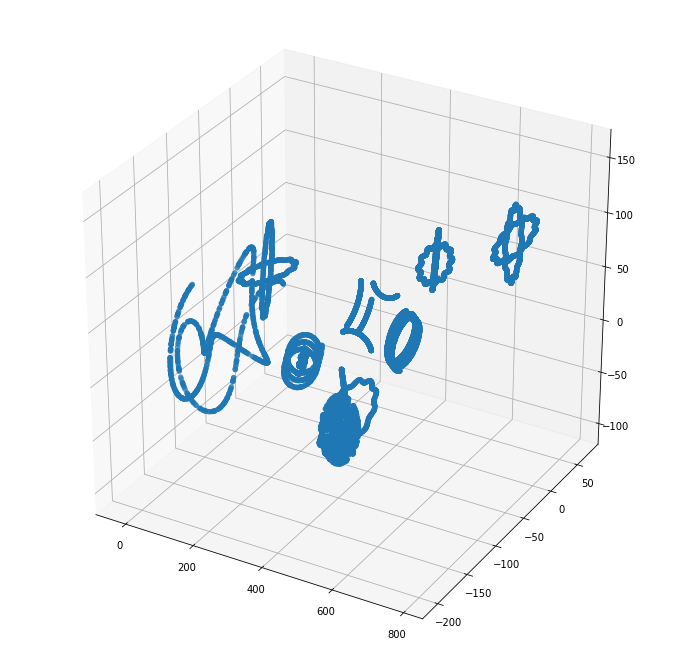

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(main_vectors[:, 0], main_vectors[:, 1], main_vectors[:, 2])
_ = plt.show()

## Estimating Local Tangent Space

In [ ]:
from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA
import skdim.id as intd


def get_best_fitting_plane_vector_pca(points, dim):
    centered = points - points.mean(axis=0)

    pca = PCA(n_components=d)

    pca.fit(centered)

    normal_vector = pca.components_[-dim:]

    return normal_vector

def get_local_tangent(main_vectors, n_neighbors):
  data_tree = KDTree(main_vectors)
  n_neigh = n_neighbors

  local_tang = np.zeros(main_vectors.shape)

  for v in tqdm(range(main_vectors.shape[0])):
    _, neigh_ind = data_tree.query(main_vectors[v:v+1], k=n_neigh)
    local_tang[v, :] = get_best_fitting_plane_vector_pca(main_vectors[neigh_ind][0], 1)[0]
  
  return local_tang

In [ ]:
local_tangent = get_local_tangent(main_vectors, n_neighbors=8)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [ ]:
from numba import njit, jit
from scipy.special import softmax

def adjusted_random_walk(main_vectors, local_tangent, n_neighbors=32, path_length=16, steps=10):

  data_tree = KDTree(main_vectors)
  n_neigh = n_neighbors

  probs_matrix = np.zeros((main_vectors.shape[0], main_vectors.shape[0]))
  # probs_matrix = np.memmap('probs_matrix.data', dtype=np.float, mode='w+',
  #                          shape=(main_vectors.shape[0], main_vectors.shape[0]))

  for step in range(steps):
    for point in tqdm(range(main_vectors.shape[0])):
      # random walk
      path = [point]
      for hop in range(path_length):
        current_state = path[-1]
        dists, neigh_ind = data_tree.query(main_vectors[current_state:current_state+1], k=n_neigh+1)
        # if np.random.uniform() < 0.5:
        neigh_ind = neigh_ind[0][1:]
        dists = dists[0][1:]
        # else:
        #   neigh_ind = neigh_ind[0][8:]
        #   dists = dists[0][8:]


        # distance probs
        dist_probs = 1.0 / (5.0 + dists)
        dist_probs = dist_probs/dist_probs.sum()

        # tangent probs
        tang_sim = np.abs(local_tangent[neigh_ind, :] @ local_tangent[current_state])
        
        # adjusted probabilities
        adjusted_probs = dist_probs * softmax(tang_sim)
        adjusted_probs = adjusted_probs / adjusted_probs.sum()


        next_neigh = np.random.choice(len(neigh_ind), p=adjusted_probs)
        next_state = neigh_ind[next_neigh]
        path.append(next_state)

      for i in range(path_length):
        probs_matrix[path[i], path[i]] += 2.0
        for j in range(i):
          probs_matrix[path[i], path[j]] += 1.0
          probs_matrix[path[j], path[i]] += 1.0
  
  return sparse.csr_matrix(probs_matrix)



def knn_tangent_aligned(main_vectors, local_tangent, n_neighbors=32):

  data_tree = KDTree(main_vectors)
  n_neigh = n_neighbors

  probs_matrix = np.eye(main_vectors.shape[0])
  # probs_matrix = np.memmap('probs_matrix.data', dtype=np.float, mode='w+',
  #                          shape=(main_vectors.shape[0], main_vectors.shape[0]))

  for point in tqdm(range(main_vectors.shape[0])):
      
    dists, neigh_ind = data_tree.query(main_vectors[point:point+1], k=n_neigh+1)
    # if np.random.uniform() < 0.5:
    neigh_ind = neigh_ind[0][1:]
    dists = dists[0][1:]
    # tangent probs
    tang_sim = np.abs(local_tangent[neigh_ind, :] @ local_tangent[point])
    for n_id in range(len(neigh_ind)):
      w = tang_sim[n_id] * 1.0/(dists[n_id] + 5)
      probs_matrix[point,neigh_ind[n_id]] = w
      probs_matrix[neigh_ind[n_id], point] = w
  
  return sparse.csr_matrix(probs_matrix)

In [ ]:
# probs_matrix = adjusted_random_walk(main_vectors, local_tangent,
#                                     n_neighbors=4, path_length=16,
#                                     steps=6)
probs_matrix = knn_tangent_aligned(main_vectors, local_tangent,
                                    n_neighbors=32)

  0%|          | 0/15000 [00:00<?, ?it/s]

## Computing the eigenvectors of the similarity matrix

In [ ]:
L = sparse.csgraph.laplacian(probs_matrix)

In [ ]:
L

<15000x15000 sparse matrix of type '<class 'numpy.float64'>'
	with 535012 stored elements in COOrdinate format>

In [ ]:
print('structural rank : ', sparse.csgraph.structural_rank(L))

structural rank :  15000


In [ ]:
# sparse eigen value
top_eigvals, top_eigvecs = sparse.linalg.eigsh(L, k=m, which='SM')

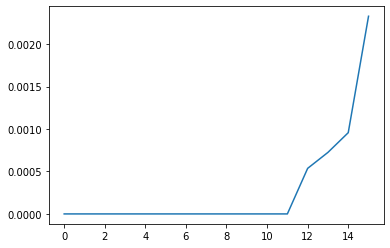

In [ ]:
_ = plt.plot(top_eigvals)

In [ ]:
top_eigvecs.shape

(15000, 16)

## Clustering

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans


gmm = GaussianMixture(n_components=m, covariance_type='full', n_init=16, random_state=0)
gmm.fit(top_eigvecs)

GaussianMixture(n_components=16, n_init=16, random_state=0)

## Spectral Clustring Based on Random Walks

In [ ]:
labels = gmm.predict(top_eigvecs)

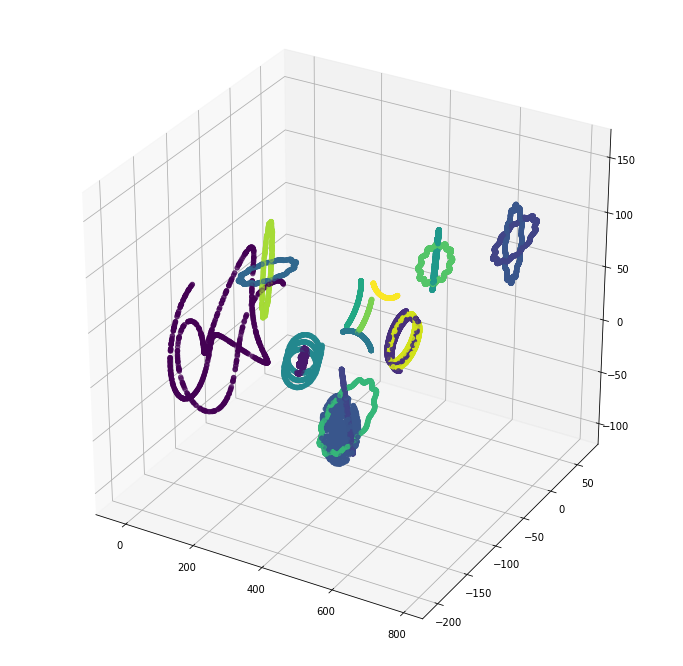

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(main_vectors[:, 0], main_vectors[:, 1], main_vectors[:, 2], c=labels)
_ = plt.show()

In [ ]:
m

16

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(main_vectors, labels)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
global_labels = clf.predict(vectors)

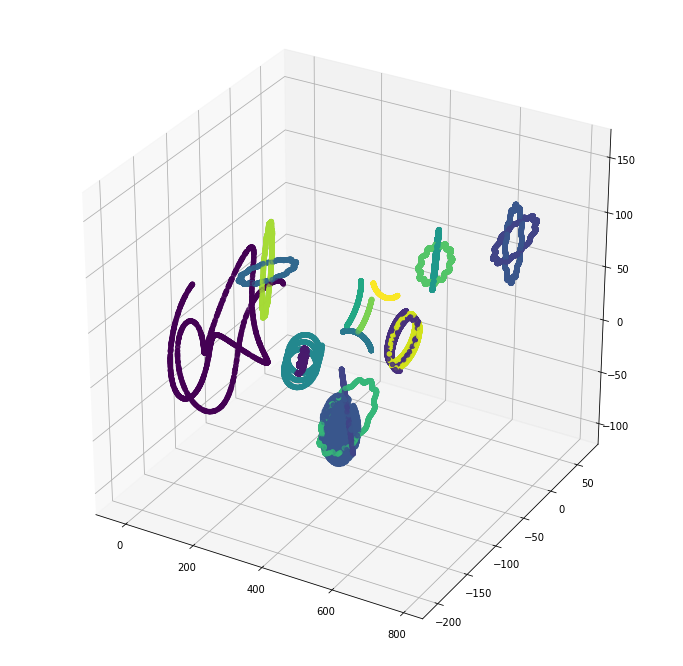

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2], c=global_labels)
_ = plt.show()

In [ ]:
s_vectors = vectors[global_labels==13]
s_local_tangent = get_local_tangent(s_vectors, n_neighbors=8)
s_probs_matrix = adjusted_random_walk(s_vectors, s_local_tangent, n_neighbors=32, path_length=20, steps=4)

  0%|          | 0/1871 [00:00<?, ?it/s]

  0%|          | 0/1871 [00:00<?, ?it/s]

  0%|          | 0/1871 [00:00<?, ?it/s]

  0%|          | 0/1871 [00:00<?, ?it/s]

  0%|          | 0/1871 [00:00<?, ?it/s]

In [ ]:
s_D = np.diag(s_probs_matrix.sum(axis=1))
s_L = s_D - s_probs_matrix
del s_D
s_gpu_L = cp.asarray(s_L)
del s_L
s_eigvals, s_eigvecs = cp.linalg.eigh(s_gpu_L)
s_top_eigvecs = cp.asnumpy(s_eigvecs[:, :20])

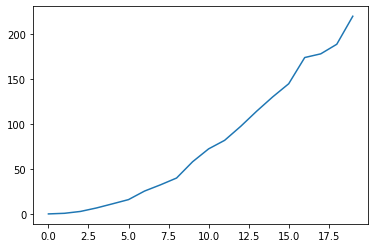

In [ ]:
_ = plt.plot(cp.asnumpy(s_eigvals[:20]))

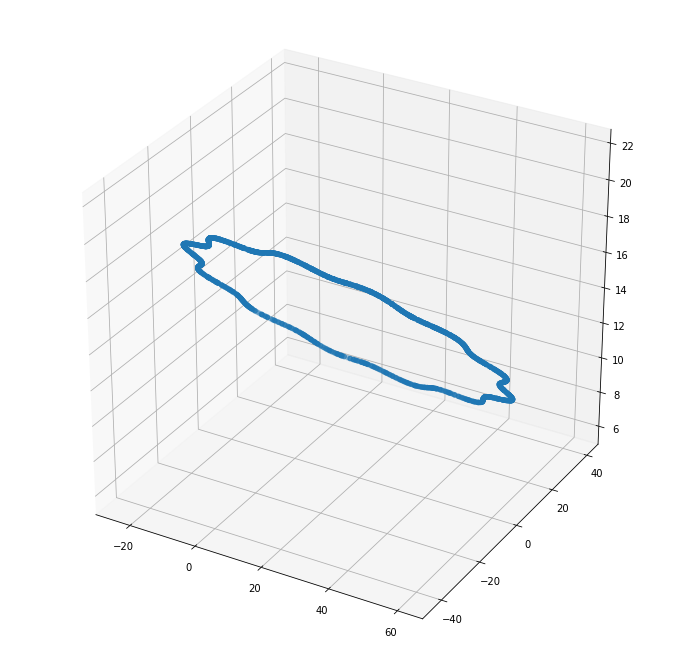

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

s_vector = vectors[global_labels==5]

ax.scatter(s_vector[:, 0], s_vector[:, 1], s_vector[:, 2])
_ = plt.show()

In [ ]:
from gap_statistic import OptimalK


def estimate_n_clusters(s_vectors):
  s_local_tangent = get_local_tangent(s_vectors, n_neighbors=8)
  s_probs_matrix = adjusted_random_walk(s_vectors, s_local_tangent,
                                        n_neighbors=32, path_length=16, steps=2)

  s_L = sparse.csgraph.laplacian(s_probs_matrix)
  s_top_eigvals, s_top_eigvecs = sparse.linalg.eigsh(s_L, k=3, which='SM')

  optimalK = OptimalK(n_jobs=4, parallel_backend='joblib')
  n_clusters = optimalK(s_top_eigvecs, cluster_array=np.arange(1, 10))

  return n_clusters



manifolds_K = []

for manifold in range(m):
  s_vectors = vectors[global_labels==manifold]
  sub_manifold_size = s_vectors.shape[0]
  s_sample_size = min(sub_manifold_size, 1000)
  s_sample_ind = np.random.choice(a=sub_manifold_size, replace=False, size=s_sample_size)
  s_vectors = s_vectors[s_sample_ind, :]
  n_clusters = estimate_n_clusters(s_vectors)
  print(f'Manifold {manifold} contains {n_clusters} sub-clusters.')
  manifolds_K.append(n_clusters)


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/945 [00:00<?, ?it/s]

Manifold 0 contains 8 sub-clusters.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Manifold 1 contains 9 sub-clusters.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
def top_k_outliers(vectors, k):
  scores = gmm.score_samples(vectors)
  top_k = np.argpartition(-scores, -k)[-k:]
  return top_k, scores[top_k]

In [ ]:
outlier_ind = []

In [ ]:
import skdim.id as intd

manifold_dims = []

for sphere in tqdm(range(m)):
  lpca = intd.lPCA().fit_pw(vectors[global_labels==sphere], n_neighbors = 128, n_jobs = 1)
  # pca = intd.DANCo().fit(vectors[global_labels==sphere])
  # manifold_dims.append(pca.dimension_)

  manifold_dims.append(int(np.round(np.quantile(lpca.dimension_pw_, 0.5))))
  

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
manifold_dims

[2, 3, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2]

In [ ]:
for manifold in range(m):
  if manifold_dims[manifold] > 2:
    manifold_dims[manifold] = 2



In [ ]:
manifold_dims

[2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2]

In [ ]:
def rank_elements(array):
  argsort = np.array(array).argsort()
  result = {i:np.where(argsort == i)[0][0] for i in range(len(argsort))}
  result = [result[i] for i in range(len(array))]
  return result

def match_K(spec, est):
  sorted_K = np.array(sorted(spec))
  ranked_est = rank_elements(est)
  return sorted_K[ranked_est]

matched_K = match_K(K, manifolds_K)
matched_K

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3])

In [ ]:
K = matched_K

In [ ]:
def estimate_n_cluster(sphere):
  points = vectors[labels==sphere]
  
  reducer = UMAP(n_components=manifold_dims[sphere],
                 densmap=True, n_neighbors=128, min_dist=0.0)
  
  points_red = reducer.fit_transform(points)

  n_clusters = optimalK(points_red, cluster_array=np.arange(2, 10))

  return n_clusters

estimated_n_clusters = []

for sphere in tqdm(range(m)):
  estimated_n_clusters.append(estimate_n_cluster(sphere))

In [ ]:
np.unique(global_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine


sub_clusters = []
for sphere in tqdm(range(m)):
  points = vectors[global_labels==sphere]
  original_index = np.where(global_labels==sphere)[0]
  cluster = SpectralClustering(n_clusters=K[sphere], random_state=0, affinity='nearest_neighbors')
  cluster.fit(points)
  submanifold_clusters = []
  for subc in range(K[sphere]):
    submanifold_clusters.append(original_index[np.where(cluster.labels_ == subc)])
  sub_clusters.append(submanifold_clusters)

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
with open('output_orange.txt', 'w+') as fp:
  fp.write(f'{n} {m}\n')
  for sphere in range(m):
    fp.write(f'{manifold_dims[sphere]} {K[sphere]} Complex\n')
    # if manifold_dims[sphere] == d:
    #   fp.write('\n')
    # else:
    #   for i in range(affine_a[sphere].shape[1]):
    #     fp.write(' '.join(affine_a[sphere][:, i].astype(str).tolist()) + '\n')
    #   fp.write(' '.join(affine_b[sphere].astype(str).tolist()) + '\n')
    # fp.write(' '.join(manifold_center[sphere, :].astype(str).tolist()) + f' {manifold_radius[sphere]} \n')
    for subc in range(K[sphere]):
      subc_points = sub_clusters[sphere][subc]
      fp.write(f'{len(subc_points)} ')
      fp.write(' '.join((subc_points+1).astype(str).tolist()))
      fp.write('\n')
  fp.write(f'{p}')
  if p > 0:
    fp.write(' ' + ' '.join((outlier_ind+1).astype(str).tolist()))